In [1]:
import collections
import cProfile
import hashlib
import itertools
import math
import os
import pstats
import string
import re

from datetime import datetime
from io import StringIO
from tqdm.notebook import tqdm as tqdm

import torch
import torchaudio
from torch import nn, topk
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS, LIBRISPEECH
from torchaudio.transforms import MFCC, Resample

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Empty CUDA cache
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

In [2]:
audio_backend = "soundfile"
torchaudio.set_audio_backend(audio_backend)

device = "cuda" if torch.cuda.is_available() else "cpu"
num_devices = torch.cuda.device_count()
print(num_devices, "GPUs")

# max number of sentences per batch
batch_size = 2048

training_percentage = 100.
validation_percentage = 0.

data_loader_training_params = {
    "num_workers": 0,
    "pin_memory": False,
    "shuffle": True,
    "drop_last": True,
}
data_loader_validation_params = data_loader_training_params.copy()
data_loader_validation_params["shuffle"] = False

non_blocking = data_loader_training_params["pin_memory"]


# text preprocessing

char_null = "-"
char_pad = "*"

labels = [char_null + char_pad + string.ascii_lowercase]

# excluded_dir = ["_background_noise_"]
# folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]


# audio

sample_rate_original = 16000
sample_rate_new = 1600
# resample = Resample(sample_rate_original, sample_rate_new)

n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,  # (160, 80)
}
mfcc = MFCC(sample_rate=sample_rate_original, n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)
# mfcc = None


# Optimizer

optimizer_params_adadelta = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
    # "weight_decay": .01,
}

optimizer_params_adam = {
    "lr": .05,
    "eps": 1e-8,
    "weight_decay": .01,
}

optimizer_params_sgd = {
    "lr": .001,
    "weight_decay": .0001,
}

Optimizer = Adadelta
optimizer_params = optimizer_params_adadelta

gamma = 0.95


# Model

lstm_params = {
    "num_layers": 3,
    "batch_first": True,
    "bidirectional": True,
    # "dropout": 0.1,
}

clip_norm = 0.  # 10.

zero_infinity = False

max_epoch = 200
mod_epoch = 10

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")
print(dtstamp)

2 GPUs
200307.190332


# Text encoding

In [3]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            return "".join(self._map(tensor))


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length
print(vocab_size)

28


# Dataset

In [4]:
class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._id = id(self)
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)

In [5]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    base_name = os.path.basename(filename)

    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")
    
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result


class FILTERED_SPEECHCOMMANDS(SPEECHCOMMANDS):
    def __init__(self, tag, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if training_percentage < 100.:
            testing_percentage = (100. - training_percentage - validation_percentage)
            which_set = lambda x: which_set(x, validation_percentage, testing_percentage) == tag
            self._walker = list(filter(which_set, self._walker))


# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2]
    # pick first channel, apply mfcc, tranpose for pad_sequence
    if mfcc is not None:
        transformed = mfcc(transformed)
    else:
        transformed.unsqueeze(1)
        transformed = resample(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    # print(target)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    # print(target)
    return transformed, target


class PROCESSED_SPEECHCOMMANDS(FILTERED_SPEECHCOMMANDS):

    def __getitem__(self, n):
        item = super().__getitem__(n)
        return process_datapoint(item)

    def __next__(self):
        item = super().__next__()
        return process_datapoint(item)


def datasets():
    root = "./"

    training = PROCESSED_SPEECHCOMMANDS("training", root, download=True)
    training = MapMemoryCache(training)
    validation = PROCESSED_SPEECHCOMMANDS("validation", root, download=True)
    validation = MapMemoryCache(validation)
    testing = PROCESSED_SPEECHCOMMANDS("testing", root, download=True)
    testing = MapMemoryCache(testing)

    return training, validation, testing

In [6]:
training, validation, _ = datasets()

In [7]:
def collate_fn(batch):

    tensors = [b[0] for b in batch if b]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    targets = [b[1] for b in batch if b]
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=tensors.device
    )
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    # print(targets.shape)
    # print(decode(targets.tolist()))
    
    return tensors, targets, target_lengths


# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [8]:
def weight_init(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)


class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x)
        return x
    

class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # batch: (batch_size, num_features, seq_len)
        y_pred = self.layers(batch)
        # y_pred: (batch_size, num_classes, output_len)
        y_pred = y_pred.transpose(-1, -2)
        # y_pred: (batch_size, output_len, num_classes)
        return nn.functional.log_softmax(y_pred, dim=-1)    

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, num_features, num_classes, lstm_params):
        super().__init__()
        
        bidirectional = lstm_params["bidirectional"]
        
        if bidirectional:
            directions = 2
        else:
            directions = 1

        self.layer = nn.LSTM(num_features, hidden_size=num_classes, **lstm_params)
        self.hidden2class = nn.Linear(directions*num_classes, num_classes)

    def forward(self, batch):
        self.layer.flatten_parameters()
        # batch: batch, num_features, seq_len
        batch = batch.transpose(-1, -2).contiguous()
        # batch: batch, seq_len, num_features
        outputs, _ = self.layer(batch)
        # outputs: batch, seq_len, directions*num_features
        outputs = self.hidden2class(outputs)
        # outputs: batch, seq_len, num_features
        return nn.functional.log_softmax(outputs, dim=-1)    

# Word Decoder

In [10]:
def greedy_decoder(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

# Train

In [11]:
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, **data_loader_training_params
)

loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, **data_loader_validation_params
)

num_features = next(iter(loader_training))[0].shape[1]
print(num_features)

13


In [12]:
model = Wav2Letter(num_features, vocab_size)
# model = LSTMModel(num_features, vocab_size, lstm_params)

# model = torch.jit.script(model)
# model = nn.DataParallel(model, [0,1]) if num_devices > 1 else model
model = nn.DataParallel(model) if num_devices > 1 else model
model = model.to(device, non_blocking=non_blocking)
# model.apply(weight_init)

optimizer = Optimizer(model.parameters(), **optimizer_params)
scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = ReduceLROnPlateau(optimizer)

criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)
# criterion = nn.MSELoss()
# criterion = torch.nn.NLLLoss()

best_loss = 1.

In [13]:
def forward_and_loss(inputs, targets, target_lengths):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)
    
    # keep batch first for data parallel
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    seq_len = outputs.shape[0]
    input_lengths = torch.full((this_batch_size,), seq_len, dtype=torch.long, device=outputs.device)
    
    # CTC    
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_and_decode(inputs, targets):
    output = model(inputs)
    output = output.transpose(0, 1)
    output = output[:, 0, :]
    output = greedy_decoder(output)
    output = decode(output.tolist())
    target = decode(targets.tolist()[0])

    print_length = 20
    output = output.ljust(print_length)[:print_length]
    target = target.ljust(print_length)[:print_length]

    return f"Epoch: {epoch:4}   Target: {target}   Output: {output}"

In [14]:
sum_loss_training = []
sum_loss_validation = []

with tqdm(total=max_epoch, unit_scale=1) as pbar:
    for epoch in range(max_epoch):
        model.train()

        sum_loss = 0.
        for inputs, targets, target_lengths in loader_training:

            loss = forward_and_loss(inputs, targets, target_lengths)
            sum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            if clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

            pbar.update(1/len(loader_training))

        # Average loss
        sum_loss = sum_loss / len(loader_training)
        sum_loss_training.append((epoch, sum_loss))
        sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"
        
        # scheduler.step()
        # scheduler.step(sum_loss)
        
        with torch.no_grad():

            if not epoch % mod_epoch:
            
                # Switch to evaluation mode
                model.eval()
        
                print(forward_and_decode(inputs, targets))

                sum_loss = 0.
                for inputs, targets, target_lengths in loader_validation:

                    sum_loss += forward_and_loss(inputs, targets, target_lengths).item()

                # Average loss
                sum_loss = sum_loss / len(loader_validation)
                sum_loss_validation.append((epoch, sum_loss))
                sum_loss_str += f"   Validation: {sum_loss:.5f}"

                print(forward_and_decode(inputs, targets))

                print(sum_loss_str)

                if sum_loss < best_loss:
                    # Save model
                    torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")
                    best_loss = sum_loss


Epoch:    0   Target: up------               Output: ----------------    
Epoch:    0   Target: go                     Output: ----------------    
Epoch:    0   Train: 9.75371   Validation: 4.04054
Epoch:   10   Target: five----               Output: ----------------    
Epoch:   10   Target: go                     Output: ----------------    
Epoch:   10   Train: 3.14282   Validation: 3.11383
Epoch:   20   Target: no------               Output: ----------------    
Epoch:   20   Target: go                     Output: ----------------    
Epoch:   20   Train: 2.30974   Validation: 2.21042
Epoch:   30   Target: sheila--               Output: -sheeila--------    
Epoch:   30   Target: go                     Output: ----------------    
Epoch:   30   Train: 1.18551   Validation: 1.10775


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   80   Target: house---               Output: -------housee---    
Epoch:   80   Target: go                     Output: --------ggo-----    
Epoch:   80   Train: 0.19239   Validation: 0.21074
Epoch:   90   Target: cat-----               Output: caat------------    
Epoch:   90   Target: go                     Output: ----------goo---    
Epoch:   90   Train: 0.15122   Validation: 0.13084
Epoch:  100   Target: five----               Output: ffive-----------    
Epoch:  100   Target: go                     Output: ----------ggo---    
Epoch:  100   Train: 0.12557   Validation: 0.11680


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  150   Target: sheila--               Output: ssheilaa--------    
Epoch:  150   Target: go                     Output: -----------goo--    
Epoch:  150   Train: 0.06156   Validation: 0.04552
Epoch:  160   Target: bird----               Output: ---bbiirdd------    
Epoch:  160   Target: go                     Output: -----------go---    
Epoch:  160   Train: 0.05143   Validation: 0.03403
Epoch:  170   Target: stop----               Output: -----stop-------    
Epoch:  170   Target: go                     Output: ----------ggo---    
Epoch:  170   Train: 0.04462   Validation: 0.06741


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



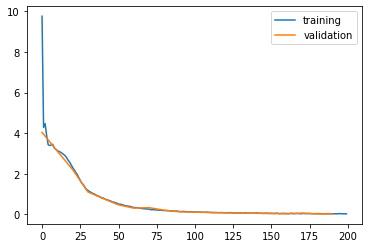

In [15]:
plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()
plt.show()

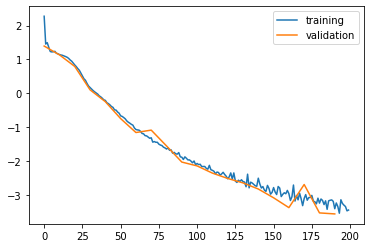

In [16]:
sum_loss_training = [(a, math.log(b)) for (a,b) in sum_loss_training]
sum_loss_validation = [(a, math.log(b)) for (a,b) in sum_loss_validation]

plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()
plt.show()

In [17]:
# Save model
torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")

# Print performance
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print(s.getvalue())

         291358480 function calls (286792519 primitive calls) in 10401.583 seconds

   Ordered by: cumulative time
   List reduced from 2417 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        7    0.000    0.000 10401.580 1485.940 base_events.py:1686(_run_once)
     51/7    0.000    0.000 10401.580 1485.940 gen.py:716(run)
    80/23    0.000    0.000 10401.580  452.243 {method 'send' of 'generator' objects}
       97    0.000    0.000 10401.580  107.233 events.py:86(_run)
       97    0.000    0.000 10401.580  107.233 {method 'run' of 'Context' objects}
       73    0.000    0.000 10401.580  142.487 ioloop.py:735(_run_callback)
        5    0.000    0.000 10401.577 2080.315 ioloop.py:690(<lambda>)
        5    0.000    0.000 10401.577 2080.315 gen.py:784(inner)
    64/18    0.001    0.000 10401.576  577.865 gen.py:184(wrapper)
       48    0.000    0.000 10401.575  216.699 kernelbase.py:347(process_one)
       32    0.001    0